#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [1]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import cv2
import os
from glob import glob

#### Load an example image

In [20]:
def load_demo_image(img_url,image_size, device):
    raw_image = cv2.imread(img_url)
    if raw_image is None:
        raise ValueError(f"Image at path '{img_url}' could not be loaded.")
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    
    # Convert from NumPy array to PIL Image
    raw_image = Image.fromarray(raw_image)
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    
    image = transform(raw_image).to(device)
    image = image.unsqueeze(0)
    return raw_image

In [9]:
def load_images_from_folder(folder_path, image_size, device):
  """Loads all images from a folder and applies preprocessing."""
  image_paths = glob(os.path.join(folder_path, "*.jpg")) + glob(os.path.join(folder_path, "*.png"))
  images = []
  for image_path in image_paths:
    try:
      raw_image = cv2.imread(image_path)
      if raw_image is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded.")
      raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

      # Convert from NumPy array to PIL Image
      raw_image = Image.fromarray(raw_image).convert('RGB')

      transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
      ])

      image = transform(raw_image).to(device)
      image = image.unsqueeze(0)
      images.append((image_path, image))
    except Exception as e:
      print(f"Error loading image {image_path}: {e}")
  return images

In [4]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


#### Load pretrained/finetuned BLIP2 captioning model

In [8]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

dict_keys(['train', 'eval'])

(360, 240)
<class 'PIL.Image.Image'>


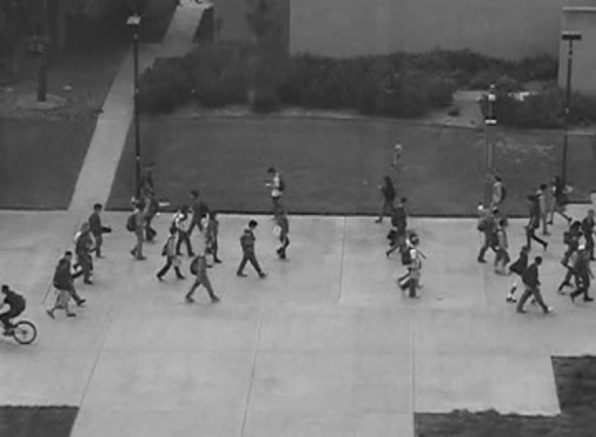

In [21]:
img_url = '120.jpg' 
raw_image = load_demo_image(img_url, 256, 'cuda') 
print(raw_image.size)
print(type(raw_image))
display(raw_image.resize((596, 437)))

In [19]:
folder = '..\..\LearningNotToReconstructAnomalies\dataset\avenue\testing\frames\01'
images=[]
if os.path.isdir(folder):
    for filename in os.listdir(folder):
        image = os.path.join(folder, filename)
        raw_image = load_demo_image(filename, 256, 'cuda')
        images.append((image,raw_image))

print(images)

[]


#### prepare the image as model input using the associated processors

In [40]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### generate caption using beam search

In [41]:
model.generate({"image": image})

['a black and white photo of a group of people walking on a sidewalk']

#### generate multiple captions using nucleus sampling

In [42]:
# due to the non-determinstic nature of necleus sampling, you may get different captions.
model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3)

['a black and white photo of a group of people walking on a sidewalk',
 'a black and white photo of people walking on a sidewalk',
 'a black and white photo of a group of people walking down a sidewalk']

#### instructed zero-shot vision-to-language generation

In [14]:
model.generate({"image": image, "prompt": "Question: do you see a cell phone in the photo and where is it? Answer:"})

["on the person's shoulder"]

In [15]:
model.generate({
    "image": image,
    "prompt": "Question: which city is this? Answer: singapore. Question: why?"})

["Answer: because it's a chinese city"]

In [12]:
context = [
    ("which city is this?", "singapore"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: which city is this? Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [13]:
model.generate(
    {
    "image": image,
    "prompt": prompt
    },
    use_nucleus_sampling=False,
)

['merlion is a portmanteau of mermaid and lion']